In [1]:
module SdrStream

using DSP
#using Plots
import DSP.firfilt          # needed to be able to extend it

export firfilt, decimateN, apply, applyN, decimaten, csrc

function firfilt(b, cx)
    CHANNEL_BUFF_SIZE = 1024
    e = eltype(cx)
    function cfirfilt(outChan)
        p = 0
        nb = length(b)
        z = zeros(e, nb)
        for x in cx
            p = p + 1
            if p>nb
                p=1
            end
            z[p] = x
            acc = 0.0
            k = p
            for j = 1:nb
                acc = acc + b[j]*z[k]
                k = k - 1
                if k < 1
                    k = nb
                end
            end
            put!(outChan, acc)
        end
    end
    return Channel(cfirfilt, ctype=e, csize=CHANNEL_BUFF_SIZE)
end



function decimateN(n, cx)
    CHANNEL_BUFF_SIZE = 1024
    n::Int64
    e = eltype(cx)
    function cdecimateN(outChan)
        for (i, x) in enumerate(cx)
            if i % n == 0
                put!(outChan, x)
            end
        end
    end
    return Channel(cdecimateN, ctype=e, csize=CHANNEL_BUFF_SIZE)
end



function apply(f, cx)
    CHANNEL_BUFF_SIZE = 1024
    e = eltype(cx)
    function capply(outChan)
        for x in cx
            put!(outChan, f(x))
        end
    end
    return Channel(capply, ctype=e, csize=CHANNEL_BUFF_SIZE)
end



function applyN(n, f, cx)
    CHANNEL_BUFF_SIZE = 1024
    n::Int
    e = eltype(cx)
    function capplyN(outChan)
        s = zeros(n)
        i = 0
        for x in cx
            i += 1
            s[i] = x
            if i == n
                put!(outChan, f(s...))
                i = 0
            end
        end
    end
    return Channel(capplyN, ctype=e, csize=CHANNEL_BUFF_SIZE)
end


# Use applyN to define the decimateN function in another way
decimaten(n, xc) = applyN(n, (x1, x2, x3)->x3, xc)



# From array to Channel
function csrc(arr)
    CHANNEL_BUFF_SIZE = 1024
    e = eltype(arr)
    return Channel(c->foreach(i->put!(c, i), arr), ctype=e, csize=CHANNEL_BUFF_SIZE)
end

end


Main.SdrStream

In [2]:
using DSP
using Plots
using Main.SdrStream

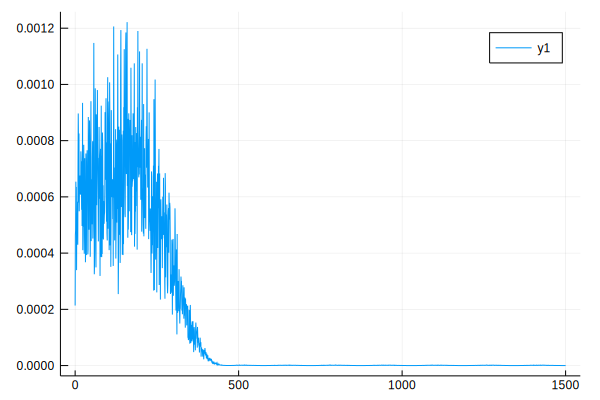

In [3]:
Fs = 3000

##############################
# Stitch multiple blocks
##############################

# [Noise Src] -> [Filter]
lpass = DSP.remez(20, [0, 0.08, 0.15, 0.5], [1.0, 0]);
xc = Channel(c->foreach(i->put!(c, randn(1)[1]), 1:40000), ctype=Float64, csize=1)
yc = firfilt(lpass, xc)
p = DSP.welch_pgram(collect(yc), 4*1024, nfft=4*1024, fs=Fs)
plot(p.freq, p.power)

In [4]:
# Another example

# [Noise Src] -> [Filter] -> [Decimate N]
lpass = DSP.remez(20, [0, 0.08, 0.15, 0.5], [1.0, 0]);
xc = Channel(c->foreach(i->put!(c, randn(1)[1]), 1:40000), ctype=Float64, csize=1)
yc = firfilt(lpass, xc)
zc = decimateN(2, yc)
p = DSP.welch_pgram(collect(zc), 4*1024, nfft=4*1024, fs=Fs);

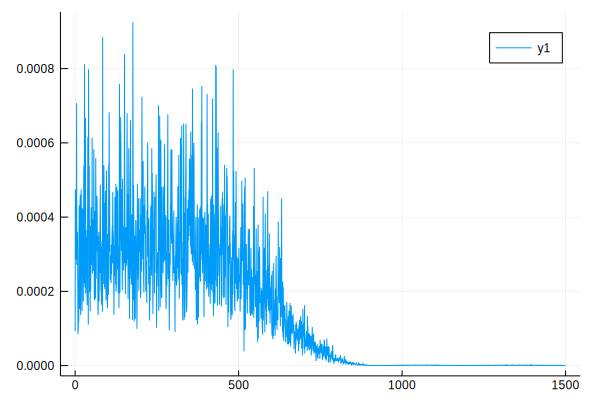

In [5]:
plot(p.freq, p.power)

In [6]:
# To be done compactly
# source
xc = Channel(c->foreach(i->put!(c, randn(1)[1]), 1:40000), ctype=Float64, csize=1)
# Processing pipeline
p = xc |> c -> firfilt(lpass, c) |> c -> decimateN(2, c) |> c -> DSP.welch_pgram(collect(c), 4*1024, nfft=4*1024, fs=Fs);

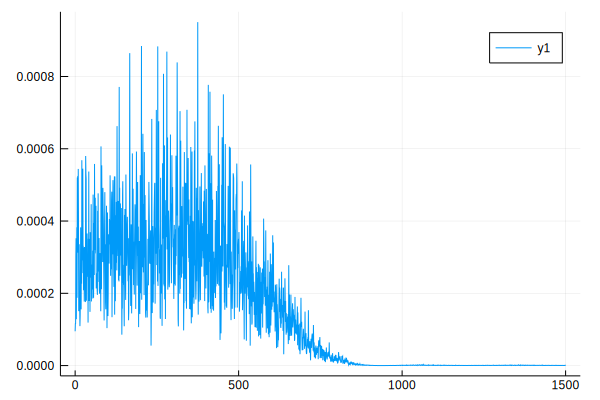

In [7]:
plot(p.freq, p.power)